In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.oriented_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Meshcat url:  http://127.0.0.1:7001/static/


In [3]:
# Draw a random sample from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = OrientedClusterRoot,
    root_node_tf = torch.eye(4)
)
torch.random.manual_seed(5)
tree = grammar.sample_tree()
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d clusters and %d boxes." % 
      (len(tree.find_nodes_by_type(OrientedCluster)),
       len(tree.find_nodes_by_type(LongBox))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.01)

[2021-08-30 22:59:11.718] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Sampled scene with 2 clusters and 4 boxes.
Sampled tree has score 12.060009
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Super tree has 13 nodes


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


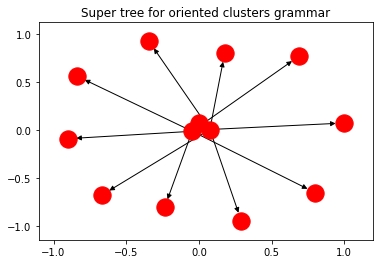

In [4]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [5]:
# Parse this tree
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True,
)
mip_optimized_tree = get_optimized_tree_from_mip_results(inference_results)
draw_scene_tree_contents_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip")
draw_scene_tree_structure_meshcat(mip_optimized_tree, zmq_url=vis.window.zmq_url, prefix="mip_scene_tree")

for node in mip_optimized_tree:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Starting setup.
Activation vars allocated.
Continuous variables allocated.
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
Setup time:  0.3979167938232422
Num vars:  2207
Num constraints:  8122
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Mon Aug 30 22:59:12 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 6043 rows, 2247 columns and 41147 nonzeros
Model fingerprint: 0x7f470992
Model has 10 quadratic constraints
Variable types: 2158 continuous, 89 integer (89 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e-01, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 5635 rows and 1827 columns
Presolve time: 0.10s
Presolv

In [6]:
# Do NLP refinement of tree
refinement_results = adjust_mle_scene_tree(mip_optimized_tree, verbose=True)
refined_tree = refinement_results.refined_tree
draw_scene_tree_contents_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined")
draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="mip_refined_scene_tree")

NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
NOT SURE IS CORRECT YET
Success?:  True
Logfile: 

         S N O P T  7.4-1.2  (Feb 2015)
1
 
 SNMEMA EXIT 100 -- finished successfully
 SNMEMA INFO 104 -- memory requirements estimated

 
 ===>  WARNING - Column      1 of the Jacobian is empty.
 ===>  WARNING - Column      2 of the Jacobian is empty.
 ===>  WARNING - Column      3 of the Jacobian is empty.
 ===>  WARNING - Column      4 of the Jacobian is empty.
 ===>  WARNING - Column      5 of the Jacobian is empty.
 ===>  WARNING - Column      6 of the Jacobian is empty.
 ===>  WARNING - Column      7 of the Jacobian is empty.
 ===>  WARNING - Column      8 of the Jacobian is empty.
 ===>  WARNING - Column      9 of the Jacobian is empty.
 ===>  WARNING - Column     43 of the Jacobian is empty.
 ===>  WARNING - Column     44 of the Jacobian is empty.
 ===>  WARNING - Column     45 of the Jacobian is empty.
 ===>  WARNING - Column     55 of the Jacobian is empt

In [7]:
try:
    mip_optimized_tree.score()
except ValueError as e:
    print("MIP optimized tree wasn't happy, as expected: %s" % str(e))

print(refined_tree.score())

MIP optimized tree wasn't happy, as expected: ('Parent <spatial_scene_grammars_examples.oriented_clusters.grammar.OrientedCluster object at 0x7f59d89464e0>, Child <spatial_scene_grammars_examples.oriented_clusters.grammar.LongBox object at 0x7f59d8946f60>: ', 'Child illegal rotated from parent: tensor([ 0.6976, -0.7165, -0.0000]) vs tensor([1., 0., 0.]), error of 45.765553 deg')
tensor([12.0600])


In [11]:
# Now try to do MCMC on the parsed tree
mcmc, discrete_choice_map = do_fixed_structure_mcmc(grammar, tree, num_samples=5, verbose=True)

Warmup:   0%|          | 0/15 [00:00, ?it/s]

Finished HMC startup


Sample: 100%|██████████| 15/15 [00:23,  1.59s/it, step size=7.62e-02, acc. prob=0.937]


                                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
             0/0/AxisAlignedBBoxRule_xyz[0]      0.05      0.03      0.05      0.01      0.08      7.76      0.72
             0/0/AxisAlignedBBoxRule_xyz[1]      0.05      0.04      0.05      0.01      0.10    -28.93      0.73
             0/0/AxisAlignedBBoxRule_xyz[2]      0.05      0.01      0.04      0.04      0.07      4.67      0.71
         0/0/UnconstrainedRotationRule_u[0]      1.18      0.27      1.15      0.84      1.57      6.44      0.71
         0/0/UnconstrainedRotationRule_u[1]      0.82      0.76      0.75      0.04      1.94      4.29      2.66
         0/0/UnconstrainedRotationRule_u[2]      1.13      0.44      1.18      0.52      1.57      3.98      2.07
             0/1/AxisAlignedBBoxRule_xyz[0]      0.02      0.01      0.03      0.00      0.03     10.27      0.71
             0/1/AxisAlignedBBoxRule_xyz[1]      0.04      0.02      0.04      0.02    

In [19]:
N_samples = mcmc.num_samples
samples = mcmc.get_samples()
transforms = mcmc.transforms
for sample_k in range(N_samples):
    continuous_choice_map = {
        key: transforms[key].inv(value[sample_k, ...]) for key, value in samples.items()}
    all_choices = {**continuous_choice_map, **discrete_choice_map}
    tree = pyro.condition(grammar.sample_tree, all_choices)()
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled/%d" % sample_k)

AssertionError: 